In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')


def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)


In [3]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01: xxx

In [4]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
#dados = down_sample(dados)

print(dados.classe.value_counts())

1    7369
0     349
Name: classe, dtype: int64


In [5]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


In [6]:
tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree)
grid_search_tree.fit(Xtrain, ytrain)

model_tree = grid_search_tree.best_estimator_
ypred_tree = model_tree.predict(Xtest)



In [7]:
from sklearn.metrics import classification_report

#print(classification_report(ytest, y_pred, target_names=target_names))
print(classification_report(ytest, ypred_tree))

             precision    recall  f1-score   support

          0       0.73      0.43      0.54        87
          1       0.97      0.99      0.98      1843

avg / total       0.96      0.97      0.96      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.5747126436781609
Cálculo de índices de avaliação:
Precisão: 0.973390; Recall: 0.992404, F1: 0.982805
Precisão CV:
[0.96907216 0.97938144 0.95876289 0.95854922 0.96373057 0.94300518
 0.96891192 0.96354167 0.97395833 0.95833333]
0.9637246719370405


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


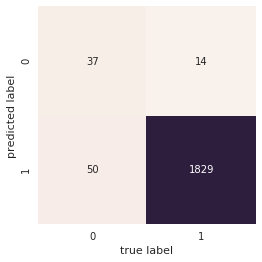

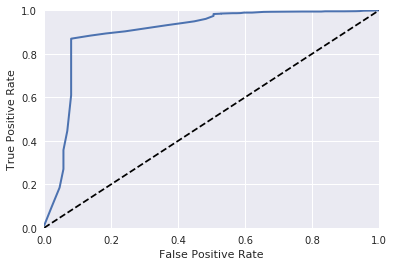

0.8985100504549677


In [8]:
evaluating(model_tree, ytest, ypred_tree, Xtest)

In [ ]:
#trabalhando com técnicas de imbalanced

In [10]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate

tree = DecisionTreeClassifier(max_features='auto')
resampled_rf = BalancedBaggingClassifier(base_estimator=tree,
                                         n_estimators=100, random_state=0)
scores = cross_validate(resampled_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.926862903945664, 0.9950539524064279)

             precision    recall  f1-score   support

          0       0.31      0.86      0.45        87
          1       0.99      0.91      0.95      1843

avg / total       0.96      0.91      0.93      1930

Valor de falso positivo:0.13793103448275862
Cálculo de índices de avaliação:
Precisão: 0.992883; Recall: 0.908302, F1: 0.948711
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.93298969 0.87113402 0.87113402 0.9015544  0.89119171 0.9119171
 0.89637306 0.93229167 0.90104167 0.88020833]
0.8989835668055483


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


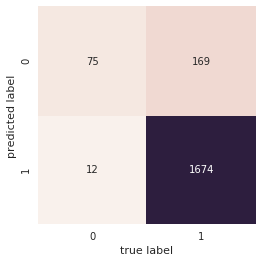

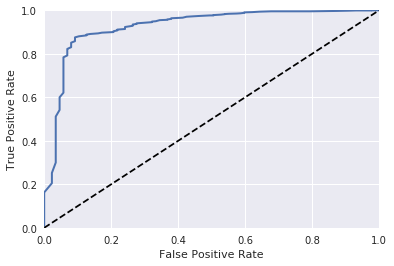

0.9270461079823625


In [11]:
ensemble = resampled_rf.fit(Xtrain, ytrain)

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

{'n_estimators': 3}
0.8521202237816129
0.86078949721114
0.9881720378507296
             precision    recall  f1-score   support

          0       0.21      0.75      0.33        87
          1       0.99      0.87      0.92      1843

avg / total       0.95      0.86      0.90      1930

Valor de falso positivo:0.25287356321839083
Cálculo de índices de avaliação:
Precisão: 0.986453; Recall: 0.869235, F1: 0.924142
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.87113402 0.85051546 0.8556701  0.88082902 0.89637306 0.83419689
 0.75647668 0.88541667 0.86979167 0.78645833]
0.8486861901963927


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


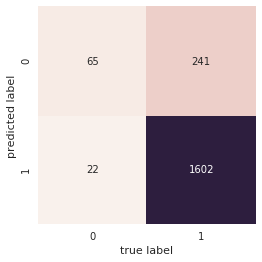

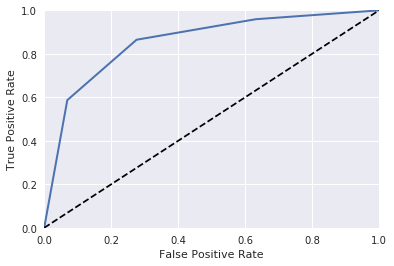

0.8557823638370723


In [7]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

# Grid search with scoring based on decision_function
#parameters = {'n_estimators': (10, 30, 100, 200, 300)}
parameters = {'n_estimators': (1, 2, 3)}

grid = GridSearchCV(BalancedBaggingClassifier(DecisionTreeClassifier(max_features='auto')),
             parameters,
             scoring="roc_auc")

grid.fit(Xtrain, ytrain)

print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

scores = cross_validate(ensemble, Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))

print(scores['test_roc_auc'].mean())
print(scores['test_average_precision'].mean())

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

In [12]:
def feature_ranking(Xtest, model, std):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show() 

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.159694)
2. feature 3 [MatemticaI120H] (0.110923)
3. feature 21 [conceito_freq_S] (0.070076)
4. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.048660)
5. feature 17 [conceito_R] (0.045513)
6. feature 9 [idade] (0.042107)
7. feature 4 [MatemticaI120H_dependencia] (0.034475)
8. feature 13 [qtd_pessoas_domicilio] (0.029831)
9. feature 78 [descricao_mae_escolaridade_Ensino médio completo] (0.028872)
10. feature 6 [acompanhamento] (0.027401)
11. feature 14 [tempo_entre_conclusao_ingresso] (0.023925)
12. feature 10 [possui_necessidade_especial] (0.021844)
13. feature 5 [MatemticaI120H_freq] (0.021464)
14. feature 12 [qnt_salarios] (0.018507)
15. feature 99 [descricao_raca_Parda] (0.014498)
16. feature 105 [descricao_responsavel_escolaridade_Ensino superior completo] (0.014128)
17. feature 40 [descricao_historico_Técnico de Nivel Médio em Informática] (0.014097)
18. feature 16 [conceito_O] (0.013919)
19. feature 88 [descrica

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


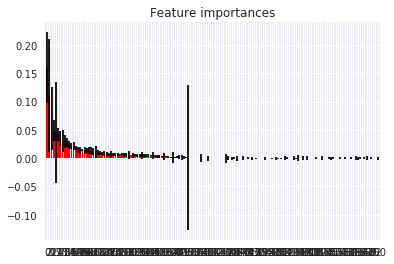

Feature ranking:
1. feature 3 [MatemticaI120H] (0.266646)
2. feature 21 [conceito_freq_S] (0.134246)
3. feature 13 [qtd_pessoas_domicilio] (0.056909)
4. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.034704)
5. feature 137 [sigla_CNAT] (0.034650)
6. feature 9 [idade] (0.025617)
7. feature 113 [descricao_responsavel_financeiro_Mãe] (0.016855)
8. feature 30 [descricao_companhia_domiciliar_Pais] (0.016622)
9. feature 15 [conceito_I] (0.016130)
10. feature 29 [descricao_companhia_domiciliar_Pai] (0.016074)
11. feature 20 [conceito_freq_R] (0.015818)
12. feature 86 [descricao_pai_escolaridade_Ensino fundamental completo] (0.015381)
13. feature 12 [qnt_salarios] (0.015348)
14. feature 5 [MatemticaI120H_freq] (0.014023)
15. feature 10 [possui_necessidade_especial] (0.013658)
16. feature 102 [descricao_responsavel_escolaridade_Ensino fundamental incompleto] (0.012554)
17. feature 131 [pessoa_fisica__sexo_M] (0.011552)
18. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.011457)
19. fea

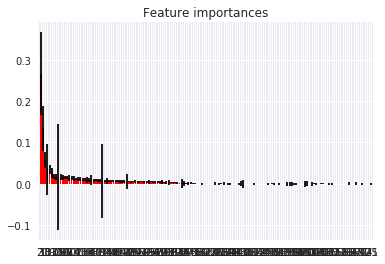

Feature ranking:
1. feature 15 [conceito_I] (0.279017)
2. feature 17 [conceito_R] (0.213172)
3. feature 5 [MatemticaI120H_freq] (0.031357)
4. feature 3 [MatemticaI120H] (0.024692)
5. feature 102 [descricao_responsavel_escolaridade_Ensino fundamental incompleto] (0.021918)
6. feature 136 [sigla_CN] (0.021561)
7. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.020401)
8. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.017017)
9. feature 100 [descricao_raca_Preta] (0.016730)
10. feature 14 [tempo_entre_conclusao_ingresso] (0.015868)
11. feature 101 [descricao_responsavel_escolaridade_Ensino fundamental completo] (0.015220)
12. feature 137 [sigla_CNAT] (0.015152)
13. feature 131 [pessoa_fisica__sexo_M] (0.014717)
14. feature 9 [idade] (0.014037)
15. feature 79 [descricao_mae_escolaridade_Ensino médio incompleto] (0.013104)
16. feature 6 [acompanhamento] (0.011497)
17. feature 40 [descricao_historico_Técnico de Nivel Médio em Informática] (0.011472)
18. feature 78 [descricao_mae_escolarida

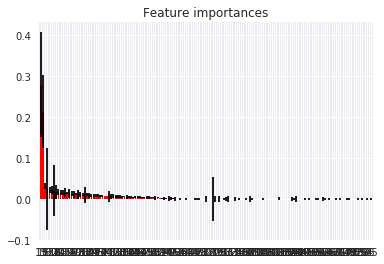

In [14]:
std = np.std([est.steps[1][1].feature_importances_ for est in ensemble.estimators_], axis=0)

for estimator in ensemble.estimators_:
    #print(estimator.steps[1][1].feature_importances_)
    feature_ranking(Xtest, estimator.steps[1][1], std)
    


In [12]:
print(np.mean([est.steps[1][1].feature_importances_ for est in ensemble.estimators_], axis=0))

[1.18970713e-01 1.94760930e-02 3.59627608e-02 1.27735829e-01
 2.64323038e-02 4.38184000e-02 9.78788299e-03 9.23557308e-03
 0.00000000e+00 3.03263975e-02 8.98452997e-03 1.71237720e-02
 1.61418343e-02 1.67691548e-02 1.58450386e-02 4.85541397e-02
 1.18034762e-02 9.11425614e-02 9.20646855e-03 1.71282684e-03
 1.01220089e-02 1.43917800e-02 2.90308025e-05 2.03754369e-03
 5.11510427e-03 4.61538425e-03 4.92415148e-03 1.81674325e-04
 3.17853104e-03 2.95294104e-03 6.50525188e-03 4.29251921e-03
 0.00000000e+00 2.67844001e-04 1.37290766e-05 4.71744234e-04
 1.14664925e-04 1.63797290e-03 2.62663007e-04 7.96956684e-04
 6.39226620e-03 4.04459357e-03 7.02128438e-04 1.80834229e-03
 5.54549966e-04 1.14150495e-03 1.47889493e-03 6.15193994e-03
 1.97917677e-03 3.63563613e-03 5.93860763e-04 1.07270684e-03
 4.98958274e-04 2.30855413e-03 1.74359681e-03 2.27484010e-04
 5.50684424e-04 1.73513121e-03 8.16600884e-04 2.49892860e-03
 1.70823788e-03 1.79177669e-03 1.66942504e-03 7.82558462e-04
 7.86596217e-04 4.493701

In [9]:
#seleciona os melhores atributos para cada modelo
selector = RFECV(ensemble, cv=10, n_jobs=-1)
selector.fit(Xtest, ytest)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n{}\n".format(best_columns))    


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

{'n_estimators': 200}
0.9187640114918161
             precision    recall  f1-score   support

          0       0.88      0.32      0.47        87
          1       0.97      1.00      0.98      1843

avg / total       0.96      0.97      0.96      1930

Valor de falso positivo:0.6781609195402298
Cálculo de índices de avaliação:
Precisão: 0.968915; Recall: 0.997830, F1: 0.983160
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.95876289 0.97938144 0.96391753 0.95854922 0.96373057 0.96373057
 0.95336788 0.97395833 0.96354167 0.94791667]
0.9626856760678738


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


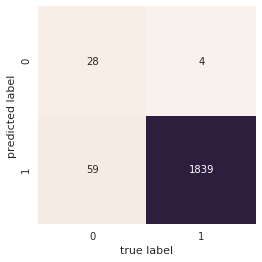

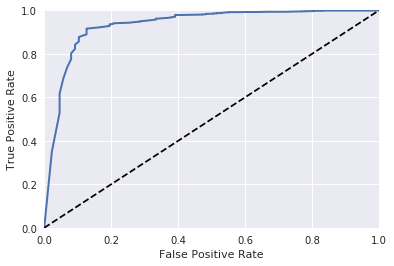

0.9321165515994037


(0.9234767493177646, 0.9942375069317352)

In [9]:
#teste atributo class_weight da RF
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

# Grid search with scoring based on decision_function
parameters = {'n_estimators': (10, 30, 100, 200)}

grid = GridSearchCV(RandomForestClassifier(max_features='auto', class_weight='balanced'),
             parameters,
             scoring="roc_auc")

grid.fit(Xtrain, ytrain)

print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

scores = cross_validate(ensemble,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [6]:
#BALANCED CASCADE

In [47]:
from imblearn.ensemble import BalanceCascade
from sklearn.base import clone

estimator = DecisionTreeClassifier(max_features='auto')

#utilizando DT
ens = BalanceCascade(estimator=estimator)
X_train_res, y_train_res = ens.fit_sample(Xtrain, ytrain)
y_pred_cum = np.zeros(len(ytest))

models = []

for idx in range(len(y_train_res)):    
    clf = DecisionTreeClassifier(max_features='auto')
    clf.fit(X_train_res[idx], y_train_res[idx]) 
    y_pred_cum += clf.predict_proba(Xtest)[:, 0]
    
    #models.append( ("est_i_{0}".format(idx), clone(clf)) )
    #models.append( clone(clf) )
    models.append( clf )


In [48]:
y_pred_cum = y_pred_cum/len(y_train_res)
ypred = (y_pred_cum < 0.5).astype(int)

In [49]:
y_pred_cum.shape
len(y_train_res)

29

In [50]:
print(X_train_res.shape)
print(X_train_res.shape)
print(X.shape)

(29, 524, 151)
(29, 524, 151)
(7718, 151)


In [71]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import numpy as np
import operator
from sklearn.base import clone

class MyEnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    clf : `iterable`
      A list of scikit-learn classifier objects.
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    def __init__(self, estimator = DecisionTreeClassifier(max_features='auto'), weights=None):
        
        self.estimator = estimator
        self.weights   = weights
        self.balanced  = BalanceCascade(estimator=estimator)
        self.clfs = []
        self.classes_ =[0, 1]
        
    def fit(self, X, y):
        """
        Fit the scikit-learn estimators.

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        
        X_train_res, y_train_res = self.balanced.fit_sample(X, y)
        
        for idx in range(len(y_train_res)):    
            
            clf = clone(self.estimator)
                
            clf.fit(X_train_res[idx], y_train_res[idx]) 
            self.clfs.append( clf )        


    def predict(self, X):
        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """
        
        #y_pred_cum = np.zeros( X.shape[0] )
        
        #for clf in self.clfs:            
        #    y_pred_cum += clf.predict_proba(X)[:, 0]
            
        #y_pred_cum = y_pred_cum/len(self.clfs)
        #maj = (y_pred_cum < 0.5).astype(int)

        maj = (self.predict_proba(X) < 0.5)[:, 0].astype(int)
        
        return maj

    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [72]:
myEns = MyEnsembleClassifier()
myEns.fit(Xtrain, ytrain)
ypred_vote = myEns.predict(Xtest)

In [73]:
ypred_vote

array([1, 1, 1, ..., 0, 1, 1])

             precision    recall  f1-score   support

          0       0.30      0.89      0.44        87
          1       0.99      0.90      0.94      1843

avg / total       0.96      0.90      0.92      1930

             precision    recall  f1-score   support

          0       0.27      0.85      0.41        87
          1       0.99      0.89      0.94      1843

avg / total       0.96      0.89      0.91      1930

Valor de falso positivo:0.11494252873563218
Cálculo de índices de avaliação:
Precisão: 0.994008; Recall: 0.900163, F1: 0.944761
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.95360825 0.94845361 0.95876289 0.95336788 0.94818653 0.93782383
 0.92227979 0.95833333 0.9375     0.92708333]
0.9445399440022791


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


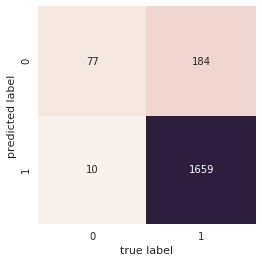

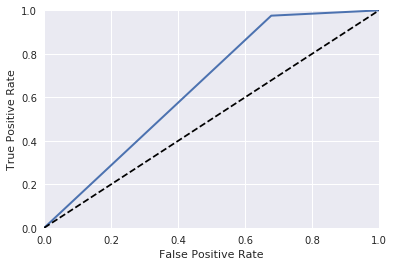

0.6487111842884852
Valor de falso positivo:0.14942528735632185
Cálculo de índices de avaliação:
Precisão: 0.992145; Recall: 0.890939, F1: 0.938822
Precisão CV:
[0.93298969 0.83505155 0.87628866 0.9119171  0.89637306 0.87046632
 0.86010363 0.92708333 0.89583333 0.859375  ]
0.8865481667200827


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


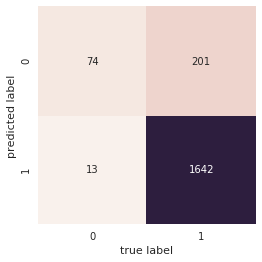

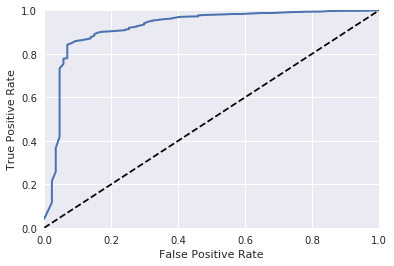

0.9218197466649204


In [74]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))
print(classification_report(ytest, ypred_vote))

evaluating(clf, ytest, ypred, Xtest)
evaluating(myEns, ytest, ypred_vote, Xtest)

#curva ROC
#fig = plt.figure()
#y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 
#y_scores = y_probas[:, 1]   # score = proba of positive class 

#fpr, tpr, thresholds = roc_curve(ytest, np.array([0.1, 0.4, 0.35, 0.8]))

#plot_roc_curve(fpr, tpr) 
#plt.show()
#print(roc_auc_score(ytest, y_scores))


In [ ]:
#FIM

In [ ]:
#exemplo
#https://pt.slideshare.net/PyData/python-resampling-65637486 
#https://www.youtube.com/watch?v=-Z1PaqYKC1w

In [ ]:
from imblearn.ensemble import BalanceCascade

RND_SEED = 0
ratio = 'auto'
estimator = RandomForestClassifier(random_state=RND_SEED)
bc = BalanceCascade(ratio=ratio, random_state=RND_SEED,
                    return_indices=False, estimator=estimator)
X_resampled, y_resampled = bc.fit_sample(Xtrain, ytrain)

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ens = BalanceCascade(classifier='adaboost')
X_train_res, y_train_res = ens.fit_sample(Xtrain, ytrain)
y_pred_proba = np.zeros(len(ytest))

for idx in range(len(y_train_res)): 
    clf = AdaBoostClassifier()
    clf.fit(X_train_res[idx], y_train_res[idx]) 
    #y_pred_proba += zip(*clf.predict_proba(Xtest))[0]
    y_pred_proba += next(zip(*clf.predict_proba(Xtest)))
    
    
y_pred_proba = y_pred_proba/len(y_train_res)
ypred = (y_pred_proba < 0.5).astype(int)



             precision    recall  f1-score   support

          0       0.25      0.87      0.38        87
          1       0.99      0.87      0.93      1843

avg / total       0.96      0.87      0.91      1930

Valor de falso positivo:0.12643678160919541
Cálculo de índices de avaliação:
Precisão: 0.993218; Recall: 0.874118, F1: 0.929870
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.95876289 0.95876289 0.94845361 0.97409326 0.96373057 0.97409326
 0.94818653 0.96354167 0.95833333 0.95833333]
0.9606291341719638


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


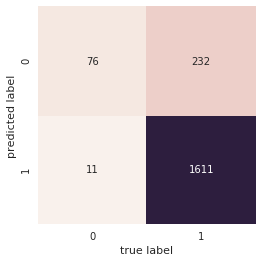

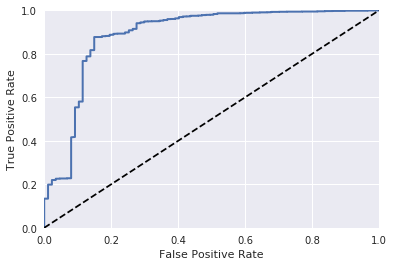

0.8868224596329075


In [19]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))
evaluating(clf, ytest, ypred, Xtest)

In [ ]:
#FIM

In [ ]:
#https://amueller.github.io/COMS4995-s18/slides/aml-13-022818-resampling-imbalanced-data/#16

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(Xtrain, ytrain)

print(Xtrain.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(5788, 151)
(524, 151)
[262 262]


In [17]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_validate(undersample_pipe,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9033623704716165, 0.9935203930343187)

In [19]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(),
                                        RandomForestClassifier())
scores = cross_validate(undersample_pipe_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.908199693226523, 0.9935355217755678)

In [21]:
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.8927508232406416, 0.9915636423533091)

In [22]:
scores = cross_validate(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9145536993861842, 0.9932346792261978)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
tree = DecisionTreeClassifier(max_features='auto')
resampled_rf = BalancedBaggingClassifier(base_estimator=tree,
                                         n_estimators=100, random_state=0)
scores = cross_validate(resampled_rf,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.926862903945664, 0.9950539524064279)

             precision    recall  f1-score   support

          0       0.31      0.86      0.45        87
          1       0.99      0.91      0.95      1843

avg / total       0.96      0.91      0.93      1930

Valor de falso positivo:0.13793103448275862
Cálculo de índices de avaliação:
Precisão: 0.992883; Recall: 0.908302, F1: 0.948711
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.93298969 0.87113402 0.87113402 0.9015544  0.89119171 0.9119171
 0.89637306 0.93229167 0.90104167 0.88020833]
0.8989835668055483


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


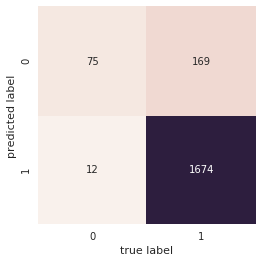

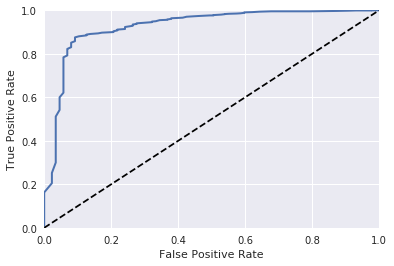

0.9270461079823625


In [32]:
#AQUIIIIIIIIII
#meus testes
ensemble = resampled_rf.fit(Xtrain, ytrain)

ypred_ensemble = ensemble.predict(Xtest)
print(classification_report(ytest, ypred_ensemble))

evaluating(ensemble, ytest, ypred_ensemble, Xtest)

In [ ]:
#FIM DE TESTE

In [24]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(Xtrain, ytrain)
enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(Xtrain, ytrain)

In [26]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegression())
scores = cross_val_score(enn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)



0.9080742611665837

In [28]:
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors= 5),
                                  RandomForestClassifier(n_estimators=100))
scores = cross_val_score(enn_pipe_rf, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

0.9200925147540447

In [30]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_sample(Xtrain, ytrain)
print(X_train_cnn.shape)
print(np.bincount(y_train_cnn))

(904, 151)
[262 642]


In [31]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(), LogisticRegression())
scores = cross_val_score(cnn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

KeyboardInterrupt: 

In [ ]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(),
                              RandomForestClassifier(n_estimators=100))
scores = cross_val_score(cnn_pipe, Xtrain, ytrain, cv=10, scoring='roc_auc')
np.mean(scores)

In [ ]:
#TESTE ENSEMBLE BALANCED

In [14]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier 

#X, y = make_classification(n_classes=2, class_sep=2,
#weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

print('Original dataset shape {}'.format(Counter(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X_train, y_train) 

y_pred = bbc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

Original dataset shape Counter({1: 7369, 0: 349})
[[  68   10]
 [ 234 1618]]
